# Random Forest Model

### Importing Libraries

In [1]:
# Installing Dependencies
%pip install pandas numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel

### Load the dataset

In [3]:
df = pd.read_csv("student_performance/StudentPerformanceFactorsAdjusted.csv")

### Data Preprocessing

In [6]:
# Define features and target
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('outlier_clip', FunctionTransformer(
        lambda X: np.clip(X, -3, 3)  # Clip outliers at 3 standard deviations
    ))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Hyperparameter Tuning

In [7]:
# Model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(
        RandomForestRegressor(n_estimators=200, random_state=42),
        max_features=20,
        threshold='median'
    )),
    ('regressor', RandomForestRegressor(
        random_state=42,
        n_jobs=-1,
        warm_start=True
    ))
])

# Optimized parameter grid
param_grid = {
    'regressor__n_estimators': [250, 300, 350],
    'regressor__max_depth': [16, 17, 18],
    'regressor__min_samples_split': [2],
    'regressor__min_samples_leaf': [1, 2, 3],
    'regressor__max_features': ['log2'],
    'regressor__bootstrap': [False]
}

# Grid search with progress tracking
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=5,
    verbose=2
)

print("Starting grid search...")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
print("Best Score:", grid_search.best_score_)


Starting grid search...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\William\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best Parameters: {'regressor__bootstrap': False, 'regressor__max_depth': 17, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 350}
Best Score: -2.349788671418383


### Model Evaluation

In [8]:
# Get predictions
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("\nModel Performance Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    # Feature importance analysis
    if hasattr(model, 'named_steps') and hasattr(model.named_steps['regressor'], 'feature_importances_'):
        # Get original feature names
        numeric_features = X_test.select_dtypes(include=['int64', 'float64']).columns
        categorical_features = X_test.select_dtypes(include=['object']).columns
        
        # Create feature names list
        feature_names = list(numeric_features)
        for cat_feature in categorical_features:
            unique_values = X_test[cat_feature].unique()
            feature_names.extend([f"{cat_feature}_{val}" for val in unique_values])
            
        # Get top N features by importance
        n_features = len(model.named_steps['regressor'].feature_importances_)
        feature_names = feature_names[:n_features]  # Trim to match actual features used
        
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': model.named_steps['regressor'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))
    
    return rmse, mae, r2, y_pred

In [9]:
default_model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(
        RandomForestRegressor(n_estimators=200, random_state=42),
        max_features=20,
        threshold='median'
    )),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit and evaluate default model
print("Training model with default parameters...")
default_model.fit(X_train, y_train)
print("\nDefault Model Performance:")
rmse_default, mae_default, r2_default, _ = evaluate_model(default_model, X_test, y_test)

# Now proceed with grid search (existing code)
print("\nStarting grid search for hyperparameter tuning...")

Training model with default parameters...

Default Model Performance:

Model Performance Metrics:
RMSE: 2.18
MAE: 1.09
R²: 0.66

Top 10 Most Important Features:
                          feature  importance
1                      Attendance    0.384692
0                   Hours_Studied    0.247164
3                 Previous_Scores    0.094042
4               Tutoring_Sessions    0.037802
2                     Sleep_Hours    0.032018
5               Physical_Activity    0.029632
8        Parental_Involvement_Low    0.021553
6     Parental_Involvement_Medium    0.019454
7       Parental_Involvement_High    0.017773
12  Extracurricular_Activities_No    0.014600

Starting grid search for hyperparameter tuning...


In [11]:
print("\nPerformance Comparison:")
print("Default vs Tuned Model")
print("-" * 40)
print(f"RMSE: {rmse_default:.2f} -> {rmse:.2f}")
print(f"MAE:  {mae_default:.2f} -> {mae:.2f}")
print(f"R²:   {r2_default:.2f} -> {r2:.2f}")
print(f"Improvement in RMSE: {((rmse_default - rmse) / rmse_default) * 100:.2f}%")


Performance Comparison:
Default vs Tuned Model
----------------------------------------
RMSE: 2.18 -> 2.09
MAE:  1.09 -> 1.02
R²:   0.66 -> 0.69
Improvement in RMSE: 4.37%


In [10]:
# Evaluate model
rmse, mae, r2, y_pred = evaluate_model(best_model, X_test, y_test)


Model Performance Metrics:
RMSE: 2.09
MAE: 1.02
R²: 0.69

Top 10 Most Important Features:
                          feature  importance
1                      Attendance    0.345409
0                   Hours_Studied    0.219062
3                 Previous_Scores    0.092839
4               Tutoring_Sessions    0.046591
2                     Sleep_Hours    0.042104
5               Physical_Activity    0.040634
8        Parental_Involvement_Low    0.021642
6     Parental_Involvement_Medium    0.020458
14          Motivation_Level_High    0.015765
12  Extracurricular_Activities_No    0.015712


### Visualizations

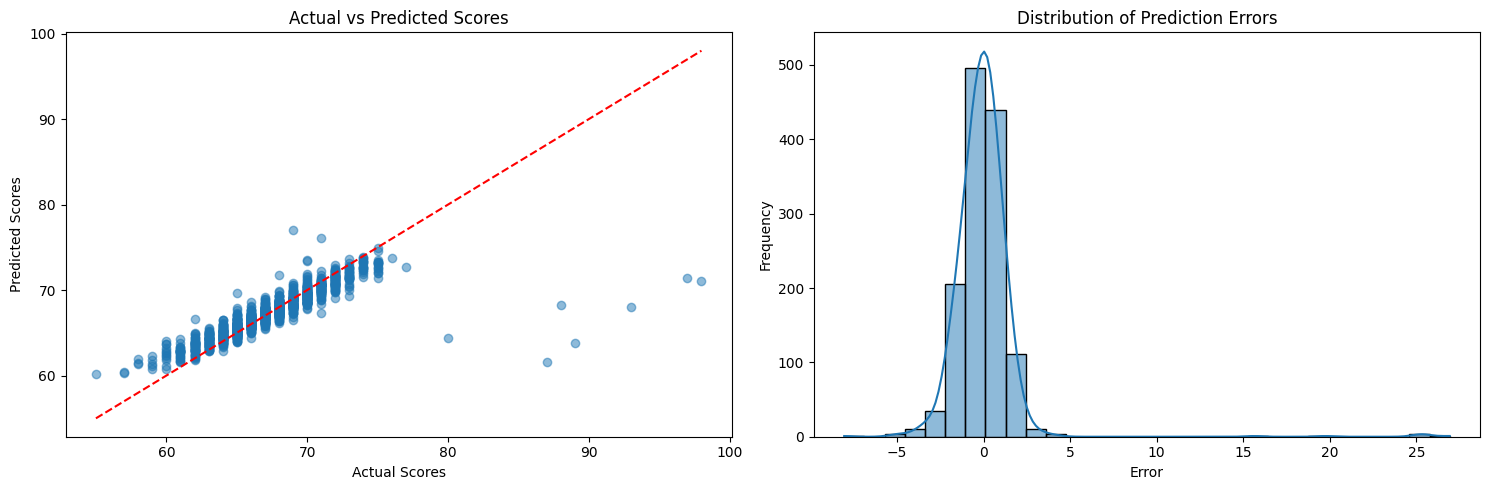

In [12]:
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')

# Error Distribution
plt.subplot(1, 2, 2)
errors = y_test - y_pred
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()